## Exploring data

This notebook will give an overview of a typical exploratory workflow in earth science. 

In [1]:
# Standard libraries:
import numpy as np              # basic math operations
import matplotlib as mpl        # making plots
import matplotlib.pyplot as plt # pyplot in particular
import pandas as pd             # useful for dealing with tabulated data
import cartopy.crs as ccrs      # maps
import io                      

# Earthquake specific
from obspy.clients.fdsn import Client  # obspy is a well maintained toolbox for processing seismological data
from obspy import UTCDateTime          # https://docs.obspy.org/

from matplotlib import patheffects
from owslib.wmts import WebMapTileService

mpl.rcParams['figure.dpi']= 200 # make our figure higher resolution

ModuleNotFoundError: No module named 'pandas'

## The global earthquake catalog:

There are a handful of online repositories that maintain global earthquake catalogs.

Important resources include:
* ANSS Comprehensive Earthquake Catalog (ComCat)
* Incorporated Research Institutions for Seismology (IRIS)

Local catalogs that are particularly well instrumented and maintained include:
* Southern California Earthquake Data Center (SCEDC)
* Japan Meteorological Agency Earthquake Catalog (JMA1)

Lets go ahead an download a typical earthquake catalog. Here, I am getting the last year of earthquakes with magnitude greater than $M_W4.0$. This can take some time.

In [2]:
client = Client("IRIS")

#  By default, events are retrieved from the NEIC PDE catalog for recent
#  events and then the ISC catalog when it becomes available. These default
#  results include only that catalog's "primary origin" and
#  "primary magnitude" for each event, they may optionally include all
#  available magnitude estimates.

# https://docs.obspy.org/packages/autogen/obspy.clients.fdsn.client.Client.get_events.html

starttime         = UTCDateTime("2019-01-01")
endtime           = UTCDateTime("2020-01-01")

minimum_magnitude = 4.5            

iris_catalog      = client.get_events(starttime=starttime, 
                              endtime=endtime, 
                              magnitudetype='MW', 
                              minmagnitude=minimum_magnitude)
print(iris_catalog)

NameError: name 'Client' is not defined

So what is the catalog?

https://docs.obspy.org/packages/autogen/obspy.core.event.Catalog.html

In [15]:
# The catalogs is a Object of the Obspy Class Catalog
print('type:',type(iris_catalog))

# Catalog can be indexed...
print(iris_catalog[0])
print(type(iris_catalog[0]))

type: <class 'obspy.core.event.catalog.Catalog'>
Event:	2019-12-31T19:10:10.306000Z | +24.074, +121.691 | 4.6 Mwr

	            resource_id: ResourceIdentifier(id="smi:service.iris.edu/fdsnws/event/1/query?eventid=11164564")
	             event_type: 'earthquake'
	    preferred_origin_id: ResourceIdentifier(id="smi:service.iris.edu/fdsnws/event/1/query?originid=41871286")
	 preferred_magnitude_id: ResourceIdentifier(id="smi:service.iris.edu/fdsnws/event/1/query?magnitudeid=197542183")
	                   ---------
	     event_descriptions: 1 Elements
	                origins: 1 Elements
	             magnitudes: 1 Elements
<class 'obspy.core.event.event.Event'>


Here is the documentation for an Obspy Event Class:
https://docs.obspy.org/packages/autogen/obspy.core.event.event.Event.html#obspy.core.event.event.Event

We can create a simple comma seperated file that contains the information we are interested in

In [17]:
file_name         = 'ISC_catalog_{}_{}.csv'.format(starttime.year,endtime.year)

# open a new blank file with name file_name in write mode 'w'
f = open(file_name,'w')

f.write('EVENT_ID,time,lat,lon,depth,M\n')

# proceed event by event
for event in iris_catalog:
    longID  = event.resource_id.id
    ID      = longID.split("eventid=",1)[1]
    loc     = event.preferred_origin()
    lat     = loc.latitude
    lon     = loc.longitude
    dep     = loc.depth
    tim     = loc.time.matplotlib_date
    mag     = event.preferred_magnitude().mag
    f.write('{}, {}, {}, {}, {}, {}\n'.format(ID,tim,lat,lon,dep,mag))

# remember to close file
f.close()

This last code block should have created a .csv file. csv files can be read in easily using various libraries, here we will use pandas. Panda has tons(!) of really useful functionality if you are dealing with tabulated data.

In [102]:
CAT = pd.read_csv(file_name)
CAT.head()

,EVENT_ID,time,lat,lon,depth,M
0,11164564,18261.798730,24.0740,121.6908,12210.0,4.6
1,11164556,18261.793700,44.0786,150.2151,10000.0,4.8
2,11177292,18261.783653,29.5392,104.7150,42500.0,4.5
3,11164545,18261.778388,30.5338,-42.0589,10000.0,4.8
4,11164562,18261.736947,43.9969,150.2063,10000.0,4.5


**Always look at your data!**

Everytime you obtain new data make sure that you look at it here is a good checklist:

* are there dummy rows (e.g. NAN)
* is it a time series? Plot the time series
* it is a spatial data? Make a map
* plot histograms of the important columns

Text(0.5, 1.0, 'Global seismicity from 2019 to 2020')

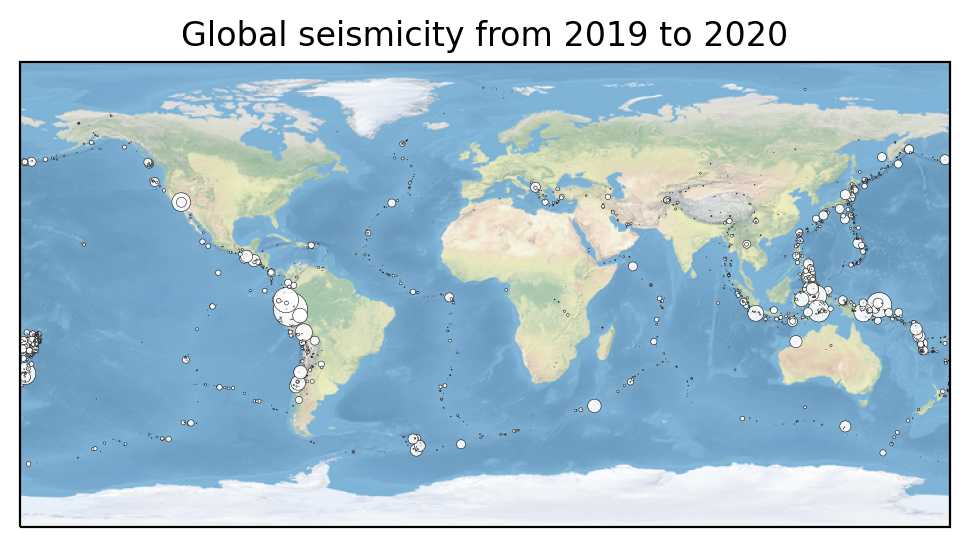

In [174]:
# https://scitools.org.uk/cartopy/docs/latest/
ax = plt.axes(projection=ccrs.PlateCarree())
ax.stock_img()
ax.scatter(CAT['lon'],CAT['lat'],
           s=(CAT['M']-4.5)**4, 
           alpha=0.9,
           c='w',
           edgecolors='k',
           linewidths=0.2,
           transform=ccrs.PlateCarree());
title_str = 'Global seismicity from {} to {}'.format(starttime.year,endtime.year)
ax.set_title(title_str)

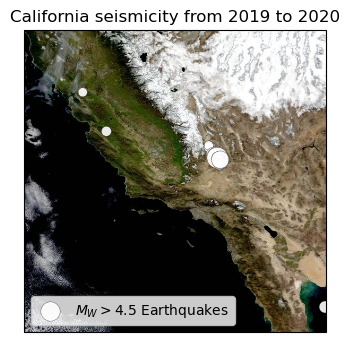

In [181]:
# URL of NASA GIBS
url = 'https://gibs.earthdata.nasa.gov/wmts/epsg4326/best/wmts.cgi'
wmts = WebMapTileService(url)

# Layers for MODIS true color and snow RGB
layer = 'MODIS_Terra_SurfaceReflectance_Bands143'
date_str = '2016-02-05'

# Plot setup
plot_crs = ccrs.PlateCarree()
geodetic_crs = ccrs.Geodetic()

x0, y0 = plot_crs.transform_point(-124, 30, geodetic_crs)
x1, y1 = plot_crs.transform_point(-114, 40, geodetic_crs)

ysize = 4
xsize = 2 * ysize * (x1 - x0) / (y1 - y0)
fig = plt.figure(figsize=(xsize, ysize), 
                 dpi=100)

ax = plt.axes(projection=plot_crs)

ax.set_xlim((x0, x1))
ax.set_ylim((y0, y1))

ax.add_wmts(wmts, layer, wmts_kwargs={'time': date_str})

ax.scatter(x=CAT['lon'],y=CAT['lat'],
           s=(CAT['M']-1)**3, 
           alpha=0.9,
           c='w',
           edgecolors='k',
           linewidths=0.2,
           transform=plot_crs,
           label='$M_W > 4.5$ Earthquakes')

title_str='California seismicity from {} to {}'.format(starttime.year,endtime.year)
ax.set_title(title_str)
ax.legend(loc='lower left')
plt.show()

### A note on making maps in python
I personally don't have a lot of experience making maps in python. Cartopy is not the most versatile tool. For more involved maps, the following resources may be better suited for your needs:

* pyGMT (https://www.pygmt.org/latest/)
* qGIS (https://qgis.org/en/site/)
* folium (https://python-visualization.github.io/folium/quickstart.html)

Note that the libraries and programs used to *make* maps may not be the programs that *host* geographic data. For topographic data, this is my go to resource:

* OpenTopography (https://portal.opentopography.org/datasets)



Text(0, 0.5, '$M_W$')

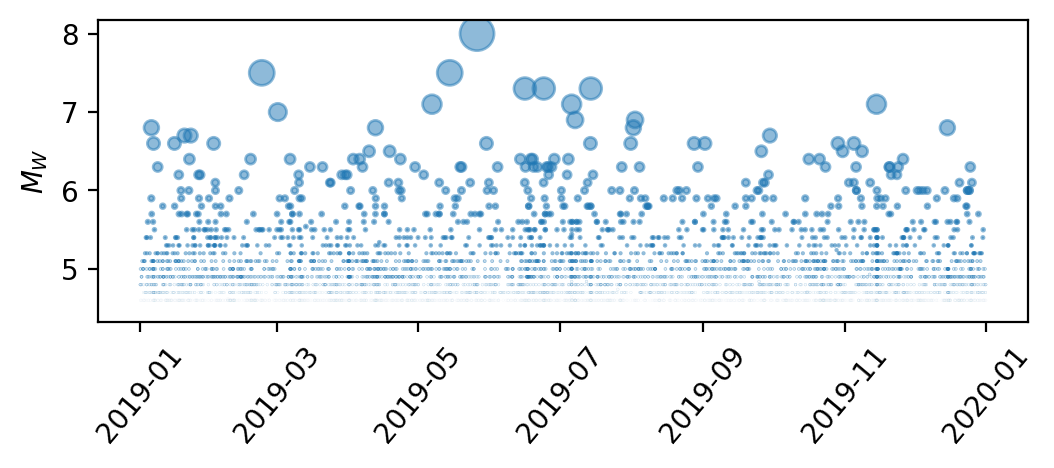

In [42]:
fig,ax= plt.subplots(figsize=(6,2))

ax.scatter(mpl.dates.num2date(CAT['time']), # Convert to dates
           CAT['M'],                        # Magnitudes
           s=(CAT['M']-4.5)**4,             # Make the size of the markers scale with magnitude
           alpha=0.5);                      # Add marker transparency

plt.setp( ax.xaxis.get_majorticklabels(), rotation=50) # rotate tick labels to avoid dates overlapping
ax.set_ylabel('$M_W$')  # make a ylabel

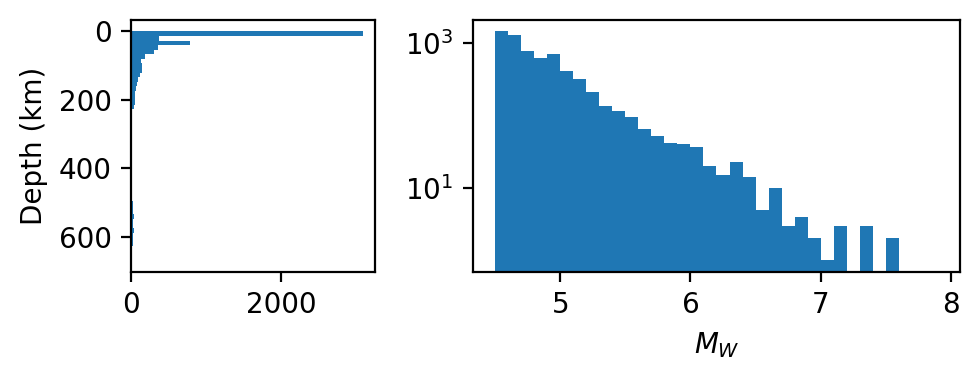

In [112]:
# Exersise make histograms of the magnitudes and the depths:
fig, ax = plt.subplots(1,2,
                       gridspec_kw={'width_ratios': [1, 2]},
                       figsize=[5,2])

ax[0].hist(CAT['depth']/1000,50,orientation='horizontal') 
ax[0].invert_yaxis()
ax[0].set_ylabel('Depth (km)')



ax[1].hist(CAT['M'],
           bins=np.arange(np.min(CAT['M']),np.max(CAT['M']),0.1))
ax[1].set_yscale('log')
ax[1].set_xlabel('$M_W$')

plt.tight_layout()

Notice that some of the depths seem to have many events at 10 and 35 km. These are default depths assigned to poorly recorded events. 

In [62]:
print('number of events at 10 km: {}'.format(np.sum(CAT['depth']==10000)))
print('number of events at 35 km: {}'.format(np.sum(CAT['depth']==35000)))

number of events at 10 km: 2807
number of events at 35 km: 438


So we can see that in a typical year there are may be 1 magnitude $M_W8$, a hand ful of $M_W7$, 10s of $M_W6$, and so on. The distribution of magnitudes is typically referred to as the Gutenberg-Righter relationship and has the form:

$$ N(M_i>M) = 10^{a-bM} $$

with $b$ typically close to 1.

There are a variety of ways to calculate the $b$-value. Perhaps the simplest to perform a linear regression. Lets see how that would look

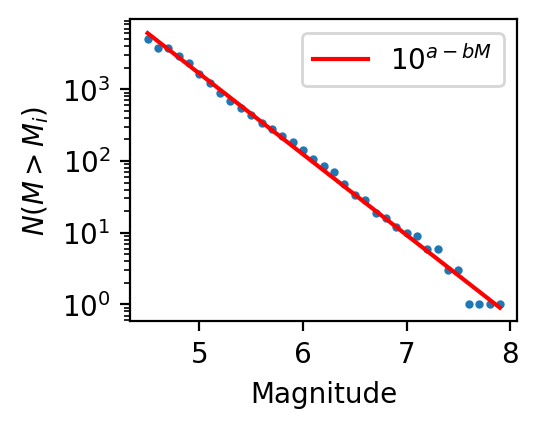

In [119]:
M = CAT['M']
    
# first we make a numpy array of the cummulative number of earthquakes:
M_array = np.arange(np.min(M),np.max(M),0.1)

# standard for loop:
# 1) make empty variable that will store the output
# 2) for i in range(number_of_loops):
# 3)     do things
# 4)     append to the variable that stores the output

N = []
for i in range(len(M_array)):
    N_i = np.sum(M>M_array[i])
    N.append(N_i)
N = np.array(N)

# next log-transform the data
logN = np.log10(N)

# perform a linear regression:
# in general for y = c0*x + c1
# [c0,c1] = np.polyfit(x,y,1)

# https://numpy.org/doc/stable/reference/generated/numpy.polyfit.html

coef = np.polyfit(M_array, logN,1)

# the fit coefficients can be found in the coef_ property 
b = -coef[0]
a = coef[1]

# make a figure 3 by 3 inches
fig, ax = plt.subplots(figsize=[2.5,2])
ax.scatter(M_array,N,
           s = 4)             # marker size
# rule of thumb: if you find yourself annoyed at long variable names make a function
def GR(M,a,b):                # here we can make a function to simplify the math
    N_predicted = 10**(a-b*M) 
    return(N_predicted)

ax.plot(M_array,GR(M_array,a,b), # use the little function defined above
        c='red',              # Make the line red
        label='$10^{a-bM}$')  # This will be the legend label

ax.set_yscale('log')          # make a log-scale y-axis
ax.set_xlabel('Magnitude')    # add x-label
ax.set_ylabel('$N(M>M_i)$')   # add y-label
ax.legend()                   # add legend 

In [101]:
# exercise turn the above into a function

def get_b_value(M):
    # first we make a numpy array of the cummulative number of earthquakes:
    M_array = np.arange(np.min(M),np.max(M),0.1)

    # standard for loop:
    # 1) make empty variable that will store the output
    # 2) for i in range(number_of_loops):
    # 3)     do things
    # 4)     append to the variable that stores the output

    N = []
    for i in range(len(M_array)):
        N_i = np.sum(M>M_array[i])
        N.append(N_i)
    N = np.array(N)

    # next log-transform the data
    logN = np.log10(N)

    # perform a linear regression:
    # in general for y = c0*x + c1
    # [c0,c1] = np.polyfit(x,y,1)

    # https://numpy.org/doc/stable/reference/generated/numpy.polyfit.html
    coef = np.polyfit(M_array, logN,1)

    # the fit coefficients can be found in the coef_ property 
    b = -coef[0]
    return b

b = get_b_value(M)
print(b)

1.12563708131


## Project management

There is now one size fits all approach to project management. Here are some useful guidelines.

Do...
* Comment your code (comment *then* code)
* use functions (with action names eg. get_bval, measure_height, etc.)
* help future-you
* use informative variable names
* organize you project
* use version control (git), or just keep copies of your project (storage is cheap, your time is not)
* think about one thing at a time

Do not!
* Use magic numbers
* leave commented code blocks in your code
* copy-paste
* var1, var2, var3, ... (use lists or dictionary instead)




### Weird python pitfals

List are mutable

In [126]:
a = 10
b = a
a = 5
print(a)
print(b)

print('\nLists are mutable')
a = [10]
b = a
a[0] = 5
print(a)
print(b)


5
10

Lists are mutable
[5]
[5]


Thuth-y false-y

In [130]:
a = True
print(a,bool(a))

b = False
print(b,bool(b))

c = [False]
print(c,bool(c))

d = []
print(d,bool(d))

True True
False False
[False] True
[] False
